In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Clip classification for HCP movie-watching data

15-way classification using the following models:
- Gate Recurrent Units (GRU)

In [2]:
import numpy as np
import pandas as pd
import pickle
import os
from cc_utils import _get_clip_labels

# plot
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
pio.templates.default = 'plotly_white'
from plot_utils import _hex_to_rgb, _plot_ts

colors = ["#D55E00", "#009E73", "#56B4E9", "#E69F00"]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [3]:
class ARGS():
    roi = 300
    net = 7
    roi_name = 'roi'
    zscore = 1
    k_fold = 5
    k_hidden = 32
    batch_size = 32
    num_epochs = 45
    train_size = 100
    
    #gru
    gru_layers = 1
    
    #tcn
    tcn_wind = 10 # 50
    tcn_hidden = 150
    tcn_epochs = 50
    
    #ff 
    ff_layers = 2
    
    

In [4]:
args = ARGS()

## Load results
Results used here are generated by the following files:
- clip_gru.py (GRU)

For architecture of each model, see corresponding files.

In [5]:
RES_DIR = {}
RES_DIR['gru'] = 'results/clip_gru'
RES_DIR['ff'] = 'results/clip_ff'
RES_DIR['tcn'] = 'results/clip_tcn'

In [6]:
def _get_results(args, model):
    
    if model=='gru':
        k_layers = args.gru_layers
    elif model=='ff':
        k_layers = args.ff_layers
    elif model == 'tcn':
        k_hidden = args.tcn_hidden
        num_epochs = args.tcn_epochs
    
    if model=='tcn':
        load_path = (RES_DIR['tcn'] + 
            '/%s_%d_net_%d_nw_wb' %(args.roi_name, args.roi, args.net) +
            '_trainsize_%d' %(args.train_size) +
            '_k_hidden_%d' %(k_hidden) +
            '_k_wind_%d_batch_size_%d' %(args.tcn_wind, args.batch_size) +
            '_num_epochs_%d_z_%d.pkl' %(num_epochs, args.zscore))
        
    else:
        
        load_path = (RES_DIR[model] + 
            '/%s_%d_net_%d' %(args.roi_name,args.roi, args.net) + 
            '_trainsize_%d' %(args.train_size) +
            '_k_hidden_%d' %(args.k_hidden) +
            '_k_layers_%d_batch_size_%d' %(k_layers, args.batch_size) +
            '_num_epochs_%d_z_%d.pkl' %(args.num_epochs, args.zscore))
        
        #load_path = (RES_DIR[model] + 
        #    '/%s_%d_net_%d' %(args.roi_name,args.roi, args.net) + 
        #    '_trainsize_%d' %(args.train_size) +
        #    '_kfold_%d_k_hidden_%d' %(args.k_fold, args.k_hidden) +
        #    '_k_layers_%d_batch_size_%d' %(k_layers, args.batch_size) +
        #    '_num_epochs_%d_z_%d_GSCV.pkl' %(args.num_epochs, args.zscore))
    
    with open(load_path, 'rb') as f:
        r,_ = pickle.load(f)
    
    return r

In [7]:
def _compare_mean(models, mode='train'):
    '''
    compare mean accuracy for each model
    '''
    fig = go.Figure()
    ticktext = []
    for ii, m in enumerate(models):
        if m[0]=='ff':
            args.ff_layers = m[1]
        elif m[0]=='tcn':
            args.tcn_wind = m[1]
        elif m[0]=='gru':
            args.lstm_layers = m[1]
        ticktext.append(m[2])
        
        r = _get_results(args, m[0])#[mode]
        if mode=='train':
            tag = 'train'
            multiplier = 3
        elif mode=='test':
            tag = 'test'
            multiplier = 1
            
        y = np.mean(r[tag])
        err_y = 1/np.sqrt(args.k_fold)*np.std(r[tag])

        bar = go.Bar(x=[ii], y=[y],
            error_y=dict(type='data',
                array=[multiplier*err_y], width=9),
            name=m[2],
            showlegend=True,
            marker_color=colors[ii])
        fig.add_trace(bar)

    fig.update_yaxes(range=[0, 1],
        title=dict(text='Clip Prediction Accuracy',
            font_size=25),
        gridwidth=1, gridcolor='#bfbfbf',
        tickfont=dict(size=20))
    fig.update_xaxes(showticklabels=False)
    fig.update_layout(height=500, width=450,
        font_color='black',
        legend_orientation='h',
        legend_font_size=20,
        legend_x=-0.1)
    
    return fig

In [8]:
def _compare_temporal(models, clipnames, mode='train'):
    '''
    compare temporal accuracy for each model
    '''
    k_class = len(clip_names)
    k_rows = int(np.ceil(k_class/3))
    k_cols = 3
    fig = make_subplots(rows=k_rows, cols=k_cols, 
        subplot_titles=clip_names, print_grid=False)
    
    fig_clip = {}
    for clip in clipnames:
        fig_clip[clip] = go.Figure()
        
    for ii, m in enumerate(models):
        if m[0]=='ff':
            args.ff_layers = m[1]
        elif m[0]=='tcn':
            args.tcn_wind = m[1]
        elif m[0]=='lstm':
            args.lstm_layers = m[1]
        
        r = _get_results(args, m[0])#[mode]
        if mode=='train':
            tag = 't_train'
        elif mode=='test':
            tag = 't_test'
        name = m[2]
        max_time = -100
        for jj in range(k_class):
            row = int(jj/k_cols) + 1
            col = (jj%k_cols) + 1

            showlegend = False
            if jj == 0:
                showlegend = True

            acc = r[tag][jj]
            ts = {'mean': np.mean(acc, axis=0),
                'ste': 1/np.sqrt(len(acc)) * np.std(acc, axis=0)}

            plotter = _plot_ts(ts, colors[ii],
                showlegend=showlegend, name=name)
            for trace in plotter:
                fig.add_trace(plotter[trace], row, col)
            for trace in plotter:
                fig_clip[clipnames[jj]].add_trace(plotter[trace])

            if len(ts['mean']) > max_time:
                max_time = len(ts['mean'])

    fig.update_layout(height=int(250*k_rows), width=750,
        legend_orientation='h')
    fig.update_xaxes(range=[0, max_time], dtick=30, 
        title_text='time (in s)',
        showgrid=False,
        autorange=False)
    fig.update_yaxes(range=[0, 1], dtick=0.2,
        gridwidth=1, gridcolor='#bfbfbf',
        autorange=False)
    
    return fig, fig_clip

Associate each clip with a label

In [9]:
clip_y = _get_clip_labels()
k_class = len(np.unique(list(clip_y.values())))
print('number of classes = %d' %k_class)

clip_names = np.zeros(k_class).astype(str)
clip_names[0] = 'testretest'
for key, item in clip_y.items():
    if item!=0:
        clip_names[item] = key

number of classes = 15


## See results on test data
`val` specifies results on val data

In [14]:
table = []
for model, file in RES_DIR.items():
    entry = {}
    entry['model'] = model
    r = _get_results(args, model)
    entry['train'] = np.mean(r['train'])
    entry['val'] = np.mean(r['test'])
    
    table.append(entry)

df = pd.DataFrame(table)
df

model     train       val
0   gru  0.880245  0.822623
1    ff  0.174134  0.169635
2   tcn  0.155206  0.148490

In [10]:
RES_DIR

{'gru': 'results/clip_gru', 'ff': 'results/clip_ff', 'tcn': 'results/clip_tcn'}

## Comparison of mean accuracy 
- mean across time steps in the clips

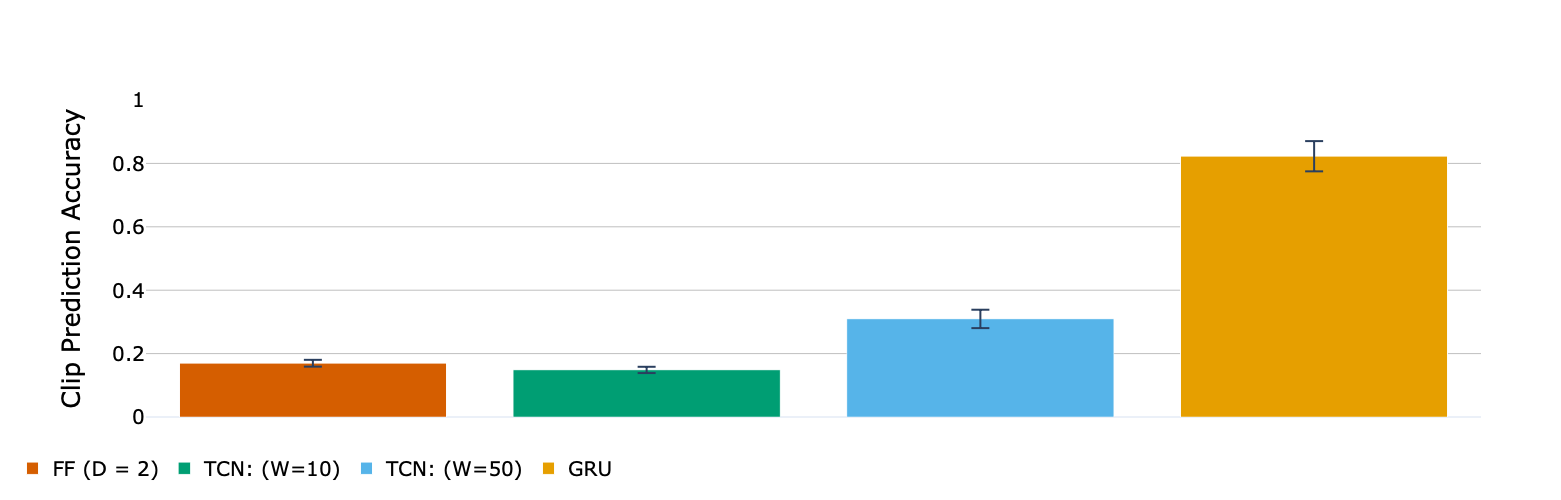

In [11]:
# model: (name, param, abbrev)

#models = [('ff', 5, 'FF: (D=5)'), 
    #('tcn', 10, 'TCN: (W=10)'), 
    #('tcn', 50, 'TCN: (W=50)'),
    #('lstm', 1, 'LSTM')]

models = [('ff', 2, 'FF (D = 2)'),
          ('tcn', 10, 'TCN: (W=10)'),
          ('tcn', 50, 'TCN: (W=50)'),
          ('gru', 1, 'GRU')]

fig = _compare_mean(models, mode='test')
fig.show()
fig_mean = go.Figure(fig)

## Comparison of temporal accuracy

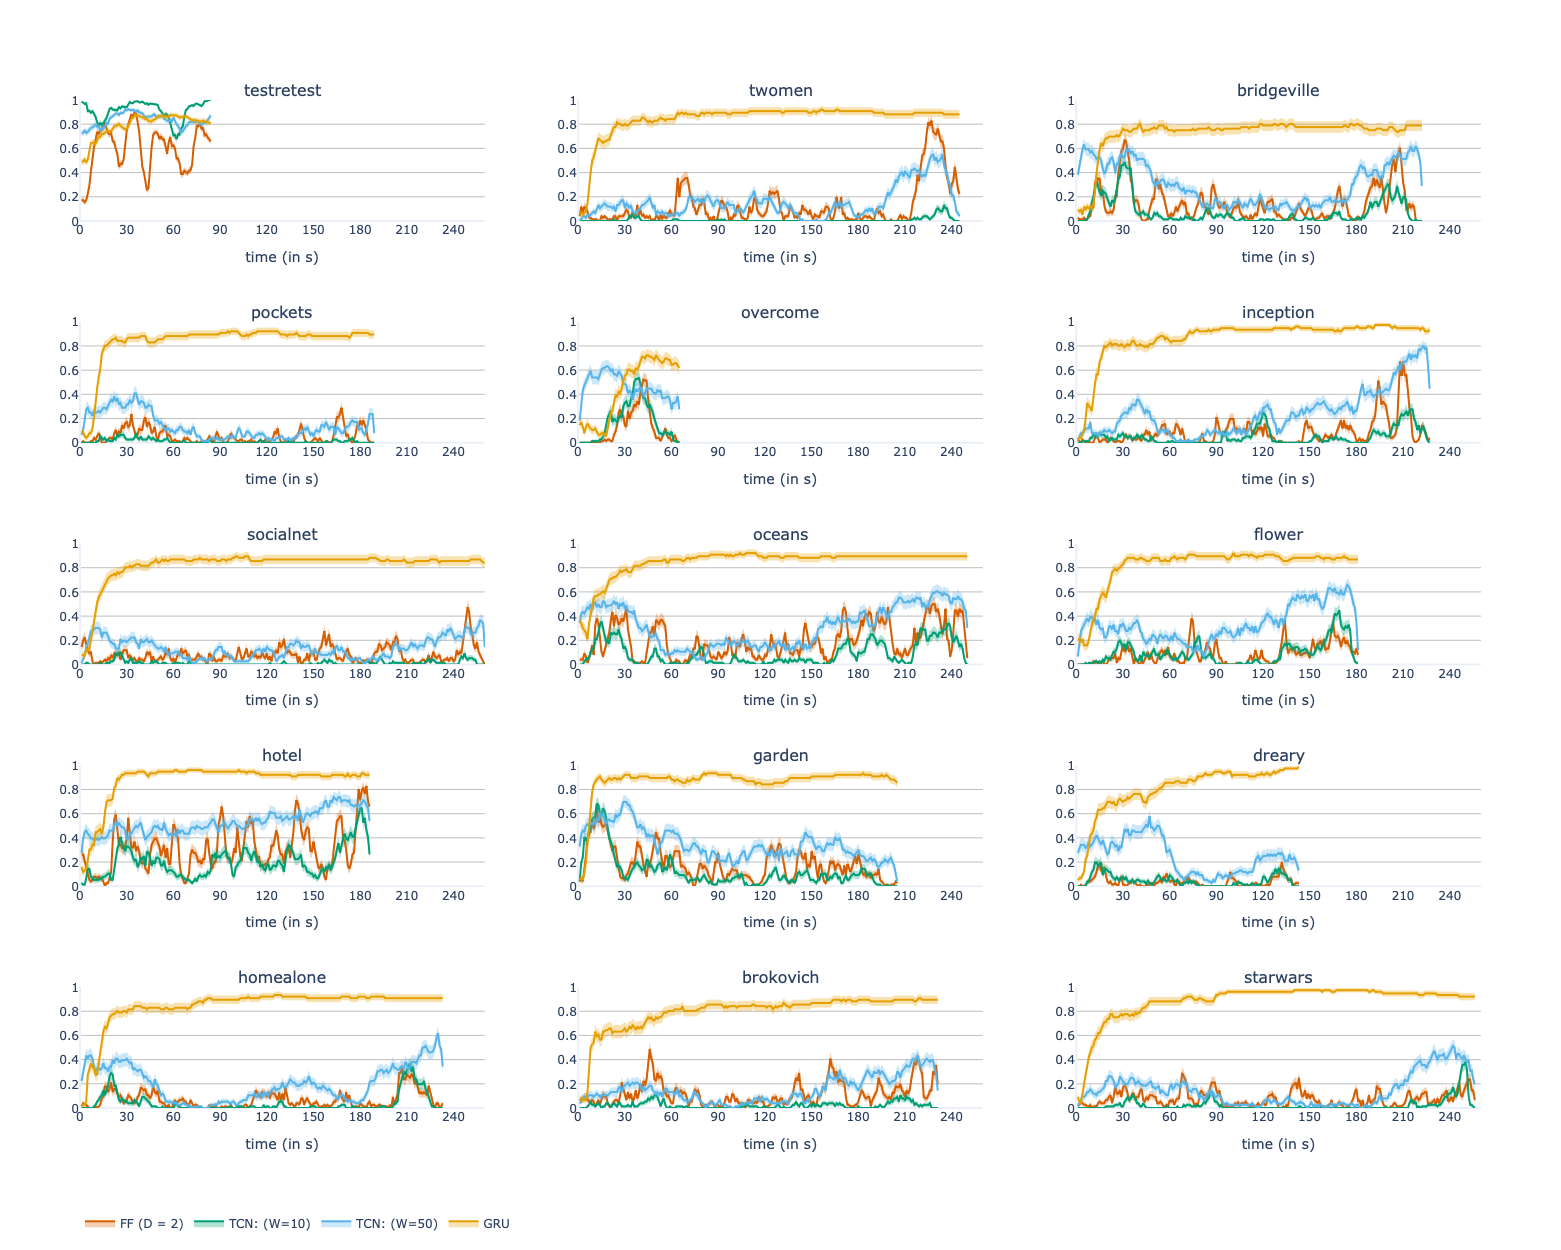

In [12]:
# model: (name, param, abbrev)

#models = [('ff', 5, 'FF: (D=5)'), 
    #('tcn', 10, 'TCN: (W=10)'), 
    #('tcn', 50, 'TCN: (W=50)'),
    #('lstm', 1, 'LSTM')]

models = [('ff', 2, 'FF (D = 2)'),
          ('tcn', 10, 'TCN: (W=10)'), 
          ('tcn', 50, 'TCN: (W=50)'),
          ('gru', 1, 'GRU')]

fig, fig_clip = _compare_temporal(models, clip_names,
    mode='test')
fig.show()

Enlarged figure for manuscript

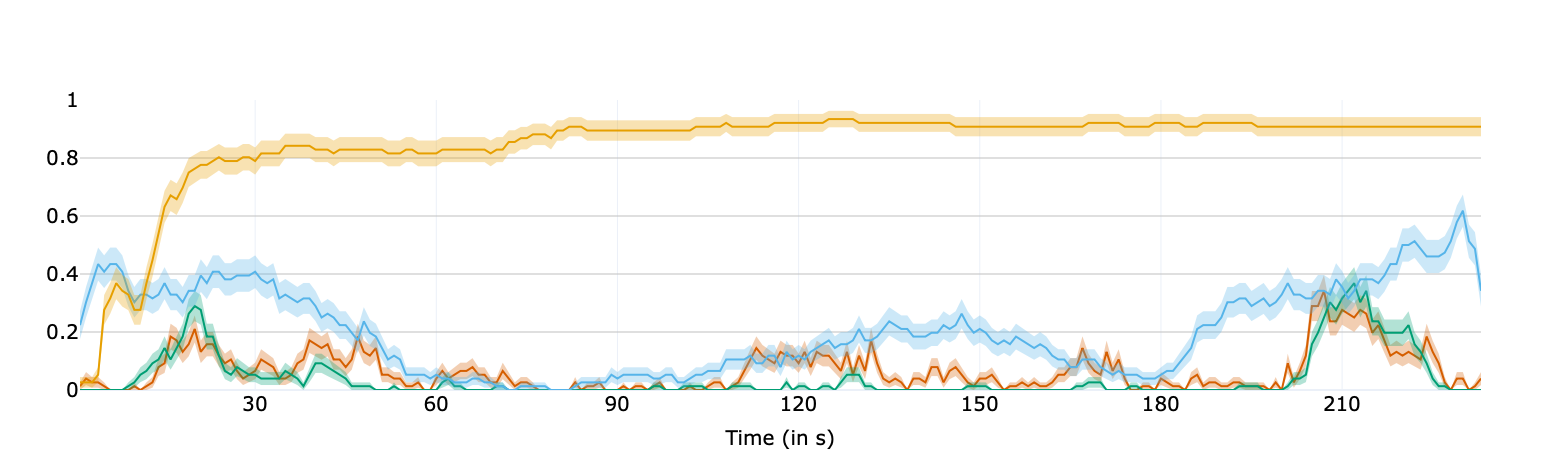

In [13]:
clip = 'homealone'
fig = fig_clip[clip]
fig.update_yaxes(range=[0, 1],
#     title=dict(text='Clip Prediction Accuracy',
#         font_size=25),
    gridwidth=1, gridcolor='#bfbfbf',
    tickfont=dict(size=20))
fig.update_xaxes(tickfont=dict(size=20),
    dtick=30,
    title=dict(text='Time (in s)', font_size=20))
fig.update_layout(height=470, width=550,
    showlegend=False,
    font_color='black',
    title='')
fig.show()